In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [35]:
data = pd.read_csv('trainingpts_cleaned.csv', index_col = 0)

data.head()

,mod_B0_0,mod_B0_1,mod_B0_2,mod_B0_3,mod_B0_4,mod_B0_5,mod_B0_6,mod_B0_7,mod_B0_8,mod_B0_9,...,EVI_at_min2_missing,EVI_at_infl2_missing,quarterPeriod_first_missing,EVI_at_peak2_missing,fittedAmplitude_second_missing,quarterPeriod_second_missing,peakDiff_missing,peakDay_first_missing,EVI_at_infl1_missing,maxEVI_second_missing
0,0.200212,0.214260,0.095794,0.237088,0.246048,0.336598,0.310465,0.270645,0.188515,0.204236,...,False,False,False,False,False,False,False,False,False,False
1,0.444825,0.378180,0.418023,0.367307,0.417435,0.362797,0.405056,0.367728,0.337898,0.318900,...,False,False,False,False,False,False,False,False,False,False
2,0.391427,0.342404,0.330443,0.335222,0.358131,0.323579,0.279447,0.416388,0.401079,0.314834,...,True,True,False,True,True,False,True,False,False,False
3,0.221930,0.175103,0.170139,0.203599,0.170929,0.260337,0.205148,0.260194,0.245417,0.328592,...,False,False,False,False,False,False,False,False,False,False
4,0.400937,0.367652,0.279104,0.299323,0.280226,0.304503,0.175922,0.198228,0.220535,0.371426,...,False,False,False,False,False,False,False,False,False,False


In [60]:
# separate the predictor names into categories (for feature selection later)

mod_ts_cols = [colname for colname in data if colname.startswith('mod')]
non_ts_cols = list(set(data.columns) - set(mod_ts_cols))
phenospectral_cols = ['EVI_at_infl2', 'quarterPeriod_first','EVI_at_min1','quarterPeriod_second','fittedAmplitude_second',
                     'EVI_at_infl1','peakDay_first','EVI_at_peak2','peakDiff', 'maxEVI_first','EVI_at_min2',
                     'peakDay_second', 'maxEVI_second', 'EVI_at_peak1', 'fittedAmplitude_first',]
missingness_cols = [colname for colname in data if colname.endswith('missing')]
geographic_cols = ['lat', 'lon', 'state', 'region']
numerical_cols = mod_ts_cols + phenospectral_cols + missingness_cols
categorical_cols = ['region', 'state']
all_predictors = list(data.columns)
all_predictors.remove('class')

In [59]:

print(all_predictors)

['mod_B0_0', 'mod_B0_1', 'mod_B0_2', 'mod_B0_3', 'mod_B0_4', 'mod_B0_5', 'mod_B0_6', 'mod_B0_7', 'mod_B0_8', 'mod_B0_9', 'mod_B0_10', 'mod_B0_11', 'mod_B0_12', 'mod_B0_13', 'mod_B0_14', 'mod_B0_15', 'mod_B0_16', 'mod_B0_17', 'mod_B0_18', 'mod_B0_19', 'mod_B0_20', 'mod_B0_21', 'mod_B0_22', 'mod_B0_23', 'mod_B0_24', 'mod_B0_25', 'mod_B0_26', 'mod_B0_27', 'mod_B0_28', 'mod_B0_29', 'mod_B0_30', 'mod_B0_31', 'mod_B0_32', 'mod_B0_33', 'mod_B0_34', 'mod_B0_35', 'mod_B0_36', 'mod_B0_37', 'mod_B0_38', 'mod_B0_39', 'mod_B0_40', 'mod_B0_41', 'mod_B0_42', 'mod_B0_43', 'mod_B0_44', 'mod_B0_45', 'mod_B0_46', 'mod_B0_47', 'mod_B0_49', 'mod_B0_50', 'mod_B0_51', 'mod_B0_52', 'mod_B0_53', 'mod_B0_54', 'mod_B0_55', 'mod_B0_56', 'mod_B0_57', 'mod_B0_58', 'mod_B0_59', 'mod_B0_60', 'mod_B0_61', 'mod_B0_62', 'mod_B0_63', 'mod_B0_64', 'mod_B0_65', 'mod_B0_66', 'mod_B0_67', 'mod_B0_68', 'mod_B0_69', 'mod_B0_70', 'mod_B0_71', 'mod_B0_72', 'mod_B0_73', 'mod_B0_74', 'mod_B0_75', 'mod_B0_76', 'mod_B0_77', 'mod_B0_

In [52]:
# include all information (timeseries, phenological and geographic) as predictors
X = data[all_predictors]
y = data['class']

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

print(y_test.head())

7927    1
1740    0
359     0
7196    1
38      0
Name: class, dtype: int64


In [76]:
# MODEL 1: mean imputation, then random forest with no parameter tuning, and using all predictors

# set predictors
numerical_cols_all = numerical_cols
categorical_cols_all = categorical_cols

# preprocessing pipelines for both numeric and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor_all = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols_all),
        ('cat', categorical_transformer, categorical_cols_all)])

# Append classifier to preprocessing pipeline
pipeline_allpred_notuning = Pipeline(steps=[('preprocessor', preprocessor_all),
                      ('rf', RandomForestClassifier())])

# training
pipeline_allpred_notuning.fit(X_train, y_train)

# prediction
acc_allpred_notuning = pipeline_allpred_notuning.score(X_test, y_test)

print(acc_allpred_notuning)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.843520090548953


In [79]:
# MODEL 2: mean imputation, random forest with no parameter tuning, using all predictors EXCEPT geographic

# set predictors
numerical_cols_nongeo = list(set(numerical_cols) - set(geographic_cols))
categorical_cols_nongeo = list(set(categorical_cols) - set(geographic_cols))

# preprocessing pipelines for both numeric and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor_nongeo = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols_nongeo),
        ('cat', categorical_transformer, categorical_cols_nongeo)])

# Append classifier to preprocessing pipeline
pipeline_nongeo_notuning = Pipeline(steps=[('preprocessor', preprocessor_nongeo),
                      ('rf', RandomForestClassifier())])

# training
pipeline_nongeo_notuning.fit(X_train, y_train)

# prediction
acc_nongeo_notuning = pipeline_nongeo_notuning.score(X_test, y_test)
print(acc_nongeo_notuning)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7606112054329371


When we get rid of geographic features, our prediction accuracy lowers from 0.84 to 0.76. This decline may be worth the extra predictive power if irrigation expands geographically.

In [82]:
# MODEL 3: random forest with tuning, using all predictors EXCEPT geographic

# set predictors
numerical_cols_nongeo = list(set(numerical_cols) - set(geographic_cols))
categorical_cols_nongeo = list(set(categorical_cols) - set(geographic_cols))

# set tuning space

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)] # Number of trees in random forest
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4] # Minimum number of samples required at each leaf node
bootstrap = [True, False] # Method of selecting samples for training each tree

# Create the random grid
random_grid = {'preprocessor__num__imputer__strategy': ['mean', 'median'],
                'rf__n_estimators': n_estimators,
               'rf__max_features': max_features,
               'rf__max_depth': max_depth,
               'rf__min_samples_split': min_samples_split,
               'rf__min_samples_leaf': min_samples_leaf,
               'rf__bootstrap': bootstrap}

# preprocessing pipelines for both numeric and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor_nongeo = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols_nongeo),
        ('cat', categorical_transformer, categorical_cols_nongeo)])

# Append classifier to preprocessing pipeline
pipeline_nongeo = Pipeline(steps=[('preprocessor', preprocessor_nongeo),
                      ('rf', RandomForestClassifier())])

rf_nongeo_tuned = RandomizedSearchCV(estimator = pipeline_nongeo, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_nongeo_tuned.fit(X_train, y_train)

print(rf_nongeo_tuned.best_params_)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 29.9min finished


NameError: name 'grid_search' is not defined

results of parameter tuning: {'rf__n_estimators': 1800,
 'rf__min_samples_split': 2,
 'rf__min_samples_leaf': 1,
 'rf__max_features': 'auto',
 'rf__max_depth': 50,
 'rf__bootstrap': False,
 'preprocessor__num__imputer__strategy': 'mean'}


In [85]:
print(("best accuracy from grid search, with no geographic features: %.3f"
       % rf_nongeo_tuned.score(X_test, y_test)))

best accuracy from grid search, with no geographic features: 0.829


Following cross validation with grid search, we find that accuracy increases to 0.83 from 0.76 without geographic features. This performance is on par with the accuracy seen with the untuned model that uses geographic features.

In [86]:
# MODEL 4: random forest with tuning, using all predictors

# set predictors
numerical_cols_all = numerical_cols
categorical_cols_all = categorical_cols

# set tuning space
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)] # Number of trees in random forest
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4] # Minimum number of samples required at each leaf node
bootstrap = [True, False] # Method of selecting samples for training each tree

# Create the random grid
random_grid = {'preprocessor__num__imputer__strategy': ['mean', 'median'],
                'rf__n_estimators': n_estimators,
               'rf__max_features': max_features,
               'rf__max_depth': max_depth,
               'rf__min_samples_split': min_samples_split,
               'rf__min_samples_leaf': min_samples_leaf,
               'rf__bootstrap': bootstrap}

# preprocessing pipelines for both numeric and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor_all = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols_all),
        ('cat', categorical_transformer, categorical_cols_all)])

# Append classifier to preprocessing pipeline
pipeline_all = Pipeline(steps=[('preprocessor', preprocessor_all),
                      ('rf', RandomForestClassifier())])

rf_all_tuned = RandomizedSearchCV(estimator = pipeline_all, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_all_tuned.fit(X_train, y_train)

print(rf_all_tuned.best_params_)

print(("best accuracy from grid search, with all features: %.3f"
       % rf_all_tuned.score(X_test, y_test)))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 27.4min finished


{'rf__n_estimators': 1600, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_features': 'sqrt', 'rf__max_depth': None, 'rf__bootstrap': False, 'preprocessor__num__imputer__strategy': 'mean'}
best accuracy from grid search, with all features: 0.882


Best hyperparameters: {'rf__n_estimators': 1600, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_features': 'sqrt', 'rf__max_depth': None, 'rf__bootstrap': False, 'preprocessor__num__imputer__strategy': 'mean'}

With all predictors, the tuned model has an accuracy of 0.88; this is slightly higher than the untuned model's accuracy of 0.84, but the gain from tuning when usign all predictors is less than the gain when avoiding geographic predictors.

In [100]:
# not all years have the same set modis columns, so before training the final model, 
# extract only the columns that are present in all years

mod_ts_cols_allyears = set(mod_ts_cols)

years_list = list(range(2004, 2014)) + list(range(2015, 2019))
for year in years_list:
    data_year = pd.read_csv('predictionpts_cleaned_' + str(year) + '.csv', index_col = 0)
    mod_ts_cols_year = [colname for colname in data_year if colname.startswith('mod')]
    mod_ts_cols_allyears = mod_ts_cols_allyears.intersection(set(mod_ts_cols_year))

print(mod_ts_cols_allyears)

{'mod_B0_69', 'mod_B0_55', 'mod_B0_47', 'mod_B0_8', 'mod_B0_28', 'mod_B0_70', 'mod_B0_67', 'mod_B0_27', 'mod_B0_34', 'mod_B0_25', 'mod_B0_26', 'mod_B0_46', 'mod_B0_29', 'mod_B0_81', 'mod_B0_56', 'mod_B0_90', 'mod_B0_24', 'mod_B0_18', 'mod_B0_32', 'mod_B0_42', 'mod_B0_10', 'mod_B0_38', 'mod_B0_15', 'mod_B0_3', 'mod_B0_45', 'mod_B0_73', 'mod_B0_79', 'mod_B0_59', 'mod_B0_84', 'mod_B0_36', 'mod_B0_40', 'mod_B0_16', 'mod_B0_88', 'mod_B0_78', 'mod_B0_11', 'mod_B0_23', 'mod_B0_72', 'mod_B0_22', 'mod_B0_65', 'mod_B0_57', 'mod_B0_43', 'mod_B0_76', 'mod_B0_80', 'mod_B0_44', 'mod_B0_64', 'mod_B0_71', 'mod_B0_37', 'mod_B0_77', 'mod_B0_7', 'mod_B0_13', 'mod_B0_19', 'mod_B0_61', 'mod_B0_58', 'mod_B0_9', 'mod_B0_54', 'mod_B0_75', 'mod_B0_62', 'mod_B0_0', 'mod_B0_66', 'mod_B0_74', 'mod_B0_31', 'mod_B0_63', 'mod_B0_82', 'mod_B0_33', 'mod_B0_35', 'mod_B0_60', 'mod_B0_53', 'mod_B0_12', 'mod_B0_20', 'mod_B0_30', 'mod_B0_21', 'mod_B0_68', 'mod_B0_14', 'mod_B0_91', 'mod_B0_17'}


In [102]:
# train final model (no geographic predictors and with tuned parameters)
# use it to make predictions of irrigation growth in other years
# use only predictors that appear in all years

# set predictors
numerical_cols_allyears = list(mod_ts_cols_allyears) + phenospectral_cols + missingness_cols
numerical_cols_nongeo = list(set(numerical_cols_allyears) - set(geographic_cols))
categorical_cols_nongeo = list(set(categorical_cols) - set(geographic_cols))

# preprocessing pipelines for both numeric and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor_nongeo = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols_nongeo),
        ('cat', categorical_transformer, categorical_cols_nongeo)])

# Append classifier to preprocessing pipeline
tuned_rf = RandomForestClassifier(n_estimators = 1800, min_samples_split = 2, 
                                   min_samples_leaf = 1, max_features = 'auto', max_depth = 50, 
                                   bootstrap = False)

pipeline_final = Pipeline(steps=[('preprocessor', preprocessor_nongeo),
                      ('rf', tuned_rf)])

# training
pipeline_final.fit(X_train, y_train)

# prediction
acc_final = pipeline_final.score(X_test, y_test)
print(acc_final)

0.8273910582908885


In [111]:
# predictions in new years

# data frame to save predicted percent irrigation in each region
columns_list = ['year', 'Brazil', 'SUL', 'CENTRO-OESTE', 'SUDESTE', 'NORDESTE', 'NORTE']
predicted_irrig = pd.DataFrame(columns = columns_list)

years_list = list(range(2004, 2014)) + list(range(2015, 2019))

for year in years_list:
    data_year = pd.read_csv('predictionpts_cleaned_' + str(year) + '.csv', index_col = 0)
    chosen_predictors = numerical_cols_nongeo + categorical_cols_nongeo
    X_year = data_year[chosen_predictors]

    prediction = pipeline_final.predict(X_year)
    
    data_year['prediction'] = prediction
    
    # percent irrigated by region
    percent_Brazil = prediction.mean()
    percent_south = data_year[data_year.region == 'SUL'].prediction.mean()
    percent_centerwest = data_year[data_year.region == 'CENTRO-OESTE'].prediction.mean()
    percent_southeast = data_year[data_year.region == 'SUDESTE'].prediction.mean()
    percent_northeast = data_year[data_year.region == 'NORDESTE'].prediction.mean()
    percent_north = data_year[data_year.region == 'NORTE'].prediction.mean()

    predicted_irrig.loc[len(predicted_irrig)] = [year, percent_Brazil, percent_south,
                                             percent_centerwest, percent_southeast,
                                             percent_northeast, percent_north]
    print(year)
    
print(predicted_irrig)

2004
2005


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (115,116,117,118,119,120,121,122,123,124,125,126,127,128,129) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2006
2007
2008


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (116,117,118,119,120,121,122,123,124,125,126,127,128,129,130) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2009


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (116,117,118,119,120,121,122,123,124,125,126,127,128,129,130) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2010
2011
2012
2013
2015
2016
2017
2018
      year    Brazil       SUL  CENTRO-OESTE   SUDESTE  NORDESTE     NORTE
0   2004.0  0.322485  0.275085      0.300594  0.470378  0.191011  0.067568
1   2005.0  0.337913  0.303962      0.316737  0.472811  0.204730  0.117647
2   2006.0  0.338471  0.328659      0.310010  0.436472  0.250543  0.155172
3   2007.0  0.346510  0.241297      0.327235  0.512838  0.286013  0.203390
4   2008.0  0.298553  0.255457      0.263432  0.418716  0.245335  0.183333
5   2009.0  0.355400  0.373338      0.285566  0.476078  0.266805  0.240000
6   2010.0  0.420304  0.266735      0.472948  0.578373  0.272349  0.279070
7   2011.0  0.364238  0.198226      0.341388  0.585892  0.309264  0.198529
8   2012.0  0.461558  0.409758      0.437120  0.602539  0.351678  0.309353
9   2013.0  0.461479  0.358826      0.447163  0.662022  0.305874  0.244755
10  2015.0  0.508090  0.361339      0.514328  0.715011  0.376615  0.242424
11  2016.0  0.448410  0.331401      0.461155  0.618550  0.31

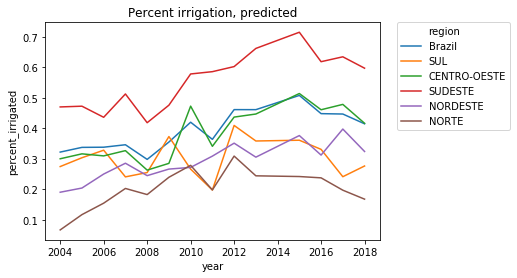

In [123]:
# plot predictions

tidy_predictions = predicted_irrig.melt(id_vars = ['year'], value_name = 'percent_irrigated', 
                                        var_name = 'region')

sns.lineplot(x = 'year', y = 'percent_irrigated', data = tidy_predictions, hue = 'region')
plt.title('Percent irrigation, predicted; not using geogrpahic predictors')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Percent irrigation increased from 2004 to 2015 in all regions, then seemed to decline from 2015 to 2018 in most places. The spatial pattern in irrigation is also apparent: irrigation is very common in the south east and least common in the north. Both the north and southeast experience a large incerase in irrigated area in the 2000s, while irrigation stayed relatively constant in the south. There's bias in the percent irrigation that we predict: areas with high irrigation frequency in 2014 (southeast) are underestimated, and areas with low irrigated frequency in 2014 (north) are overestimated. However, we can still draw insights about the temporal trends within each region.

What if we used geogrpahic predictors?

In [126]:
# train final model (no geographic predictors and with tuned parameters)
# use it to make predictions of irrigation growth in other years
# use only predictors that appear in all years

# set predictors
numerical_cols_allyears = list(mod_ts_cols_allyears) + phenospectral_cols + missingness_cols
numerical_cols_all = numerical_cols_allyears
categorical_cols_all = categorical_cols

# preprocessing pipelines for both numeric and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor_all = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols_all),
        ('cat', categorical_transformer, categorical_cols_all)])

# Append classifier to preprocessing pipeline
tuned_rf = RandomForestClassifier(n_estimators = 1600, min_samples_split = 2, 
                                   min_samples_leaf = 1, max_features = 'sqrt', max_depth = None, 
                                   bootstrap = False)
                            
pipeline_all = Pipeline(steps=[('preprocessor', preprocessor_all),
                      ('rf', tuned_rf)])

# training
pipeline_all.fit(X_train, y_train)

# prediction
acc_all = pipeline_all.score(X_test, y_test)
print(acc_all)

0.8834182229767968


In [128]:
# predictions in new years - using all predictors

# data frame to save predicted percent irrigation in each region
columns_list = ['year', 'Brazil', 'SUL', 'CENTRO-OESTE', 'SUDESTE', 'NORDESTE', 'NORTE']
predicted_irrig_all = pd.DataFrame(columns = columns_list)

years_list = list(range(2004, 2014)) + list(range(2015, 2019))

for year in years_list:
    data_year = pd.read_csv('predictionpts_cleaned_' + str(year) + '.csv', index_col = 0)
    chosen_predictors = numerical_cols_all + categorical_cols_all
    X_year = data_year[chosen_predictors]

    prediction = pipeline_all.predict(X_year)
    
    data_year['prediction'] = prediction
    
    # percent irrigated by region
    percent_Brazil = prediction.mean()
    percent_south = data_year[data_year.region == 'SUL'].prediction.mean()
    percent_centerwest = data_year[data_year.region == 'CENTRO-OESTE'].prediction.mean()
    percent_southeast = data_year[data_year.region == 'SUDESTE'].prediction.mean()
    percent_northeast = data_year[data_year.region == 'NORDESTE'].prediction.mean()
    percent_north = data_year[data_year.region == 'NORTE'].prediction.mean()

    predicted_irrig_all.loc[len(predicted_irrig_all)] = [year, percent_Brazil, percent_south,
                                             percent_centerwest, percent_southeast,
                                             percent_northeast, percent_north]
    print(year)
    
print(predicted_irrig_all)

2004
2005


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (115,116,117,118,119,120,121,122,123,124,125,126,127,128,129) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2006
2007
2008


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (116,117,118,119,120,121,122,123,124,125,126,127,128,129,130) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2009


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (116,117,118,119,120,121,122,123,124,125,126,127,128,129,130) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2010
2011
2012
2013
2015
2016
2017
2018
      year    Brazil       SUL  CENTRO-OESTE   SUDESTE  NORDESTE     NORTE
0   2004.0  0.396792  0.072696      0.254182  0.945039  0.373034  0.040541
1   2005.0  0.392685  0.060109      0.269333  0.932556  0.351811  0.058824
2   2006.0  0.398323  0.083789      0.248428  0.929296  0.403331  0.120690
3   2007.0  0.426193  0.089761      0.270518  0.960288  0.465553  0.127119
4   2008.0  0.385223  0.082538      0.226917  0.927596  0.344851  0.091667
5   2009.0  0.432473  0.141493      0.277763  0.946429  0.408177  0.096000
6   2010.0  0.468429  0.087090      0.381310  0.973214  0.446292  0.147287
7   2011.0  0.428571  0.069942      0.291003  0.970281  0.410082  0.095588
8   2012.0  0.478490  0.141249      0.354209  0.978190  0.470470  0.158273
9   2013.0  0.477939  0.127347      0.387642  0.980233  0.400405  0.125874
10  2015.0  0.504363  0.141052      0.425617  0.986354  0.456072  0.115152
11  2016.0  0.472598  0.106717      0.376992  0.977841  0.42

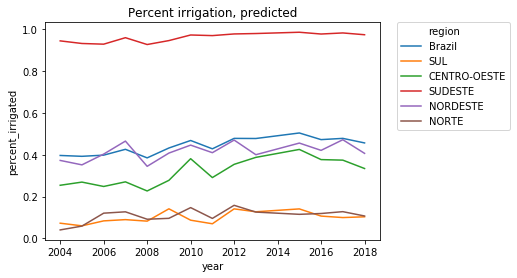

In [129]:
# plot predictions

tidy_predictions_all = predicted_irrig_all.melt(id_vars = ['year'], value_name = 'percent_irrigated', 
                                        var_name = 'region')

sns.lineplot(x = 'year', y = 'percent_irrigated', data = tidy_predictions_all, hue = 'region')
plt.title('Percent irrigation, predicted; using geographic features')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Although the classifer that is trained with geographic information has a high test accuracy, it doesn't reflect the time trends in irrigation expansion as well as a classifier that doesn't include geographic information. The percent irrigation predicted across time looks very similar to what was observed in 2014, indicating that the geographic spread of irrigation in 2014 has an overly strong pull on predicted irrigation in other years.

However, the use of regions may still be important. Because different regions have different precipitation seasonality, the modis acquisition dates that best separate the classes are different, and it may be useful to fit a separate classifier per region. 

In [137]:
# fit a separate model to each region (don't use geographic features)

percent_irrigated_perregion = pd.DataFrame({'year' : years_list})

for regionname in ['SUL', 'CENTRO-OESTE', 'SUDESTE', 'NORDESTE', 'NORTE']:
    
    # fit the model for the region ---------------------------------------------

    # set predictors
    numerical_cols_allyears = list(mod_ts_cols_allyears) + phenospectral_cols + missingness_cols
    numerical_cols_nongeo = list(set(numerical_cols_allyears) - set(geographic_cols))
    categorical_cols_nongeo = list(set(categorical_cols) - set(geographic_cols))

    # preprocessing pipelines for both numeric and categorical data
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean'))])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor_nongeo = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols_nongeo),
            ('cat', categorical_transformer, categorical_cols_nongeo)])

    # Append classifier to preprocessing pipeline
    tuned_rf = RandomForestClassifier(n_estimators = 1800, min_samples_split = 2, 
                                       min_samples_leaf = 1, max_features = 'auto', max_depth = 50, 
                                       bootstrap = False)

    pipeline_region = Pipeline(steps=[('preprocessor', preprocessor_nongeo),
                          ('rf', tuned_rf)])


    X_train_region = X_train[X_train.region == regionname]
    y_train_region = y_train[X_train.region == regionname]
    
    # training
    pipeline_region.fit(X_train_region, y_train_region)
    
    #print(regionname)
    
    yearly_percent_irrig = []
    
    for year in years_list:
        data_year = pd.read_csv('predictionpts_cleaned_' + str(year) + '.csv', index_col = 0)
        chosen_predictors = numerical_cols_all + categorical_cols_all
        X_year = data_year[chosen_predictors]
        X_year_region = X_year[data_year.region == regionname]
        prediction = pipeline_all.predict(X_year_region)

        percent_irrigated = prediction.mean()
        
        # save the year's percent irrigated
        yearly_percent_irrig.append(percent_irrigated)
        
        #print(year)
    
    # save the region's predictions
    percent_irrigated_perregion[regionname] = yearly_percent_irrig
    #print(percent_irrigated_perregion)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (115,116,117,118,119,120,121,122,123,124,125,126,127,128,129) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (116,117,118,119,120,121,122,123,124,125,126,127,128,129,130) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (116,117,118,119,120,121,122,123,124,125,126,127,128,129,130) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: Dty

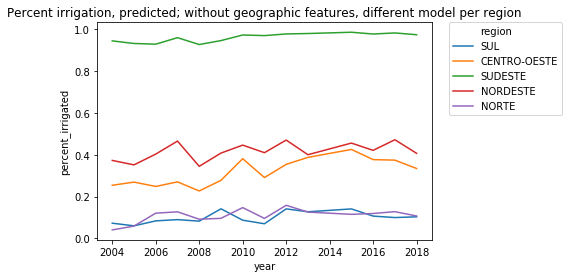

In [139]:
# plot predictions

tidy_predictions_perregion = percent_irrigated_perregion.melt(id_vars = ['year'], value_name = 'percent_irrigated', 
                                        var_name = 'region')

sns.lineplot(x = 'year', y = 'percent_irrigated', data = tidy_predictions_perregion, hue = 'region')
plt.title('Percent irrigation, predicted; without geographic features, different model per region')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

When each region is fitted with its own model, the predictions look very similar to the 2014 version. This may be an artifact of an unbalanced set of training points (in the southeast, almost all training points are irrigated; in the north, almost none are irrigated), or it may truly reflect the growth of irrigation through the years. Because seasonality changes almost as much across individual years as across the country, fitting separate models to each region may not actually capture the seasonal and phenological variability we're interested in.

Conclusion: continue using a single model across Brazil and don't include geographical features. Avoiding geographical features allows us to predict pattern of irrigation spread in space and doesn't force the model to place weight on the spatial pattern observed in the training year. Although separating models by region would in theory control for seasonality differences across space, it can't control for the interannual variability, which might be as large as the spatial variability. Also, the regions as defined here might not be the best way to divide the country by seasonality type - so we choose to fit the entire country with a single model. If we had much more training data across multiple years, we could have divided the data into categories of seasonality and fit a separate model to each seasonality type.